# Methods in Sparse Learning: from ISTA to L-ISTA

In [ ]:
import torch
import numpy as np

from matplotlib import pyplot as plt

from torch.utils import data as Data
import torch.nn.functional as F
import torch.nn as nn

import cvxpy as cp

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

The purpose of this tutorial is to get familiar with *compressive sensing* techniques aiming at the recovery of _sparse codes of signals_.

Specifically, we assume the following linear model:

\begin{equation}
\mathbf{y} = \mathbf{A}\mathbf{\Psi}\mathbf{x} + \xi
\end{equation}

which is a compressed linear measurement through the matrix $\mathbf{A} \in \mathbb{R}^{M \times N}$, with $M < N$, of a signal being sparse over a basis $\mathbf{\Psi} \in \mathbb{R}^{N \times N}$ via a code $\mathbf{x} \in \mathbb{R}^{N}$, with AWGN $\xi \sim N(0,\sigma^2\mathbb{I}_M)$.

Without loss of generality, we assume that our signal is sparse over the canonic basis $\mathbf{\Psi} = \mathbb{I}_N$, thus the estimation is a least-square one regularized by a term inducing sparsity:

\begin{equation}
    \underset{\mathbf{x}}{\mathrm{min}} \ V(\mathbf{x}) =  \  \frac{1}{2}||\mathbf{y} - \mathbf{A}\mathbf{x}||_2^2 + \lambda \|\mathbf{x}\|_1
\end{equation}

We will solve this problem in two different ways:
+ Iterative Soft Thresholding Algorithm (ISTA);
+ Deep Unrolling of the Iterative Soft Thresholding Algorithm, a learnable, neural version of the iterative scheme.


In [ ]:
class SyntheticSignals:
    def __init__(
        self,
        A=None,
        n=100,
        m=50,
        p=0.1,
        SNR=None,
        size=1000,
        batch_size=512,
        discretized=False,
        device=None,
        seed=None,
        return_numpy=False,
    ):
        '''
        Synthetic sparse signal generator with optional noise and discretization.

        Args:
            A (torch.Tensor or np.ndarray): Sensing matrix of shape (m, n).
            n (int): Signal dimension.
            m (int): Measurement dimension.
            p (float): Sparsity level (fraction of nonzero entries).
            SNR (float, optional): Signal-to-noise ratio (if None, no noise added).
            size (int): Number of samples.
            batch_size (int): Batch size for data loader.
            discretized (bool): If True, nonzero entries are ±1 instead of Gaussian.
            device (torch.device or str, optional): Device to store tensors.
            seed (int, optional): Random seed for reproducibility.
            return_numpy (bool): If True, generate data as NumPy arrays instead of Torch tensors.
        '''
        self.n = n
        self.m = m
        self.p = p
        self.SNR = SNR
        self.size = size
        self.batch_size = batch_size
        self.discretized = discretized
        self.return_numpy = return_numpy
        self.device = torch.device(device or "cpu")

        # Set random seeds
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        # Initialize sensing matrix
        if A is None:
            self.A = self._initialize_A()
        else:
            if isinstance(A, np.ndarray):
                A = torch.from_numpy(A)
            A = A.to(dtype=torch.float32, device=self.device)
            assert A.shape == (m, n), f"A must have shape ({m}, {n})"
            self.A = A

        # Generate data
        self.x, self.y = self._generate_dataset()

    def _initialize_A(self):
        '''Random Gaussian sensing matrix with normalized columns'''
        A = torch.randn(self.m, self.n, device=self.device) / np.sqrt(self.m)
        A /= torch.linalg.norm(A, dim=0, keepdim=True)
        return A

    def _generate_single(self):
        '''Generate a single (x, y) pair.'''
        x = torch.zeros(self.n, device=self.device)

        # Choose random support
        k = max(1, int(self.p * self.n))
        idxs = torch.randperm(self.n, device=self.device)[:k]

        # Generate sparse coefficients
        if self.discretized:
            values = torch.randint(0, 2, (k,), device=self.device, dtype=torch.float32) * 2 - 1
        else:
            values = torch.randn(k, device=self.device)

        x[idxs] = values
        y = self.A @ x

        # Add Gaussian noise according to SNR
        if self.SNR is not None:
            noise_var = torch.mean(y**2) / self.SNR
            y += torch.randn_like(y) * torch.sqrt(noise_var)

        return x, y

    def _generate_dataset(self):
        '''Generate the entire dataset in matrix form.'''
        X = torch.zeros(self.n, self.size, device=self.device)
        Y = torch.zeros(self.m, self.size, device=self.device)

        for i in range(self.size):
            x, y = self._generate_single()
            X[:, i] = x
            Y[:, i] = y

        if self.return_numpy:
            return X.cpu().numpy(), Y.cpu().numpy()
        return X, Y

    def get_loader(self, shuffle=True):
        '''Return a PyTorch DataLoader '''
        if self.return_numpy:
            raise ValueError("DataLoader is only available when return_numpy=False.")
        # Transpose to (size, dim) for DataLoader compatibility
        dataset = Data.TensorDataset(self.y.T, self.x.T)
        return Data.DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def to_numpy(self):
        '''Return (x, y) as NumPy arrays in shape (n, size) and (m, size).'''
        return self.x.cpu().numpy(), self.y.cpu().numpy()

    def to_torch(self):
        '''Return (x, y) as Torch tensors (n, size) and (m, size).'''
        if self.return_numpy:
            self.x = torch.from_numpy(self.x).to(self.device)
            self.y = torch.from_numpy(self.y).to(self.device)
        return self.x, self.y


In [ ]:
n_ = 400
m_ = 200
p_ = 0.01

torch.random.manual_seed(42)
A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

In [ ]:
generator = SyntheticSignals(
        A = A_,
        n = n_,
        m = m_,
        p = p_,
        SNR = None
        )

In [ ]:
X, Y = generator.to_numpy()

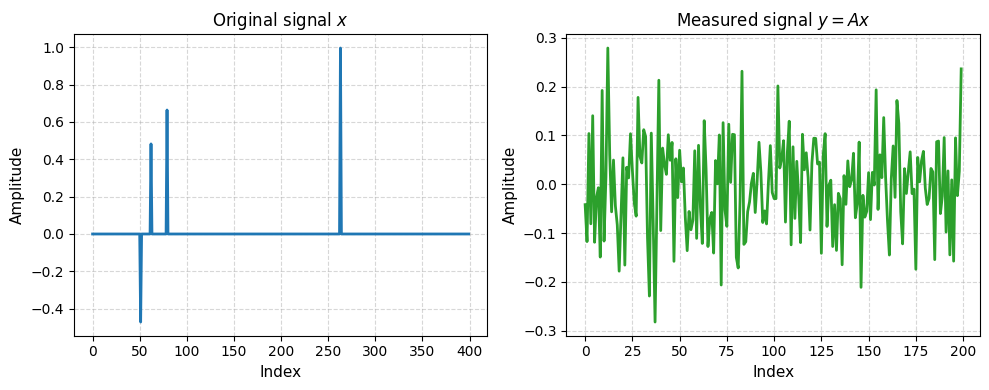

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

line_width = 2
color_x = "tab:blue"
color_y = "tab:green"

axes[0].plot(X[:, 0], color=color_x, linewidth=line_width)
axes[0].set_title(r"Original signal $x$", fontsize=12)
axes[0].set_xlabel("Index", fontsize=11)
axes[0].set_ylabel("Amplitude", fontsize=11)
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].plot(Y[:, 0], color=color_y, linewidth=line_width)
axes[1].set_title(r"Measured signal $y = A x$", fontsize=12)
axes[1].set_xlabel("Index", fontsize=11)
axes[1].set_ylabel("Amplitude", fontsize=11)
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


## Iterative Soft Thresholding Algorithm

ISTA is the name given to **proximal gradient descent** when applied to the **ℓ₁-regularized least squares** problem:
+ One step of gradient descent in the smooth term $g(\mathbf{x},\mathbf{y})=\frac{1}{2}\|\mathbf{Ax}-\mathbf{y}\|_2^2$;
+ One step of projection induced by the non-smooth regularizer $h(\mathbf{x})=\|\mathbf{x}\|_1$.

At each iteration, for $\delta$ small enough, it performs two steps:

1. **Gradient descent step**  
   \begin{equation}
   \mathbf{z} = \mathbf{x}^k - \delta\nabla g(\mathbf{x}^k,\mathbf{y})
   \end{equation}

2. **Proximal projection (soft thresholding)**  
   \begin{equation}
   \mathbf{x}^{k+1} = \mathbb{S}_{\lambda\delta}\left[ \mathbf{z} \right]
   \end{equation}

where the Soft-Thresholding operator $\mathbb{S}$ acts component-wise on the input as follows:

\begin{equation}
\mathbb{S}_{\tau}[\mathbf{z}_i] = \begin{cases}
0 & \mathrm{iff} |\mathbf{z}_i| \leq \tau \\
\mathbf{z}_i - \tau\mathrm{sign}(\mathbf{z}_i) & \mathrm{iff} |\mathbf{z}_i| \geq \tau
\end{cases} = \mathrm{sign}(\mathbf{z}_i)\mathrm{max}\{|\mathbf{z}_i|-\tau,0\}
\end{equation}


In [ ]:
def ISTA(
    A,
    Y,
    lambda_,
    max_iter=1000,
    tol=1e-6,
):

    n = A.shape[1]
    if len(Y.shape) == 1:
        Y = Y.reshape(-1, 1)

    n_snapshots = Y.shape[1]
    X = np.zeros((n, n_snapshots))

    # Define the stepsize and the main loop
    '''
    Your code goes here
    '''

    return X


In [ ]:
# Test cell
x = X[:,0]
y = Y[:,0]
A = generator.A.cpu().numpy().astype(np.float32)

x_hat = ISTA(A, y, 0.1)

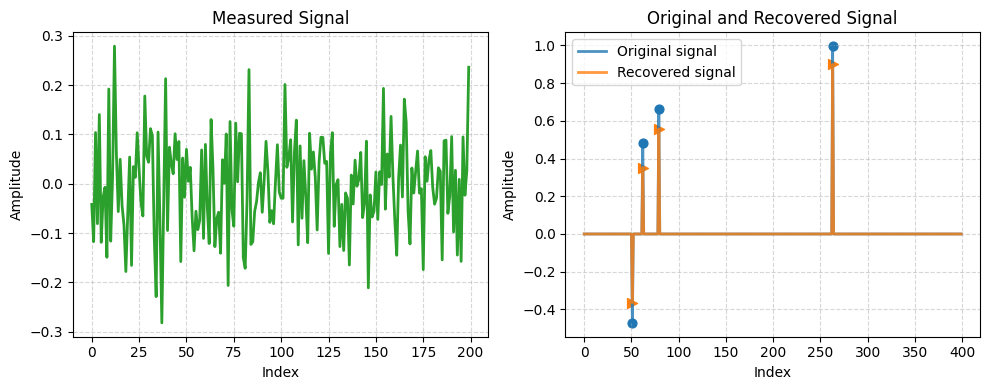

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

mask_X = np.abs(X[:, 0]) > 1e-3
mask_xhat = np.abs(x_hat) > 1e-3

axes[0].plot(Y[:, 0], linewidth = 2, color="tab:green")
axes[0].set_title("Measured Signal")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(X[:, 0], label="Original signal", linewidth = 2, color="tab:blue", alpha=0.8)
axes[1].plot(x_hat, label="Recovered signal", linewidth = 2, color="tab:orange", alpha=0.8)

axes[1].scatter(np.where(mask_X)[0], X[mask_X, 0], color="tab:blue", marker='o', s=40,)
axes[1].scatter(np.where(mask_xhat)[0], x_hat[mask_xhat], color="tab:orange", marker='>', s=50,)

axes[1].set_title("Original and Recovered Signal")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Amplitude")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Learnable ISTA: proximal gradient descent goes neural

In this section we'll implement and train a LISTA model, a neural network where each layer resambles one iteration of the ISTA algorithm. It is fully described by the following recursion:
\begin{equation}
\mathbf{x}^{k+1} = \mathbb{S}_{\beta^k} [ \mathbf{W}_1^k\mathbf{y} + \mathbf{W}_2^k\mathbf{x}^k]
\end{equation}
where at each $k$-th layer there are learnable linear transformations $\mathbf{W}_1^k, \mathbf{W}_2^k$ and (learnable) nonlinearities given by the soft-thresholding algorithm.

For our purposes, we will implement it with shared parameters (many techniques to reduce the space-complexity of LISTA have been proposed, if you are interested on them contact me!) in the following simplified form:

\begin{equation}
\mathbf{x}^{k+1} = \mathbb{S}_{\beta^k} [ \mathbf{x}^k - \mu^k(\mathbf{W}_2\mathbf{x}^k-\mathbf{W}_1\mathbf{y})]
\end{equation}

**REQUIREMENTS**
+ Implement the LISTA class from its initializer: initialize two linear layers of the proper dimension (pay attention on how data are shaped and how batches are processed from data loader), and also learnable parameters for the stepsize $\mu$ and the threshold $\beta$ at each layer, providing a model-inspired initialization;
+ Implement the shrinkage function leveraging native pytorch routines (https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.softshrink.html);
+ Implement the neural recursion as a forward loop.

In [ ]:
class LISTA(nn.Module):
    def __init__(
        self,
        A,
        T = 6,
        beta_0 = 0.1
        ):

        super(LISTA, self).__init__()
        '''
        Your code goes here
        '''

    def _shrink(self, s, beta):
        '''
        Your code goes here
        '''

    def forward(self, y, x_true = None):
        '''
        Your code goes here
        '''

In [ ]:
def train(model, train_loader, valid_loader, num_epochs=50):
    """
    Train a network.

    Args:
        model (torch.nn.Module): The neural network model.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        valid_loader (torch.utils.data.DataLoader): DataLoader for validation data.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    # Main loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (y, x) in enumerate(train_loader):
            x_hat, _ = model.forward(y)
            loss = F.mse_loss(x_hat, x, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        for step, (y, x) in enumerate(valid_loader):
            x_hat, _ = model.forward(y)
            test_loss += F.mse_loss(x_hat, x, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

In [ ]:
def LISTA_apply(train_loader, test_loader, T, A, beta_0):
    n = A.shape[0]
    m = A.shape[1]
    lista = LISTA(A = A, T = T, beta_0 = beta_0)
    train(lista, train_loader, test_loader)

    # Extract all samples and calculate MSE for each iteration
    y, x_true = test_loader.dataset.tensors
    _, mse_vs_iter = lista(y, x_true=x_true)

    return lista, np.array(mse_vs_iter)/len(test_loader.dataset)

def ISTA_apply(test_loader, A, lambda_=0.1, max_iter=1000, tol=1e-6):

    # Convert A to NumPy if needed
    if isinstance(A, torch.Tensor):
        A = A.detach().cpu().numpy()

    # Extract full dataset as NumPy arrays
    y_torch, x_true_torch = test_loader.dataset.tensors
    Y = y_torch.detach().cpu().numpy().T  # shape: (m, n_snapshots)
    X_true = x_true_torch.detach().cpu().numpy().T  # shape: (n, n_snapshots)

    # Precompute constants
    L = np.linalg.norm(A.T @ A, ord=2)
    n = A.shape[1]
    n_snapshots = Y.shape[1]

    # Initialization
    X = np.zeros((n, n_snapshots))
    prev_X = np.copy(X)

    mse_vs_iter = np.zeros(max_iter)

    # ISTA loop
    for t in range(max_iter):
        # Gradient step
        Z = X - (1 / L) * (A.T @ (A @ X - Y))

        # Soft thresholding
        X = np.sign(Z) * np.maximum(np.abs(Z) - lambda_ / L, 0)

        # Compute MSE at this iteration (averaged over all snapshots)
        mse_vs_iter[t] = np.mean(np.linalg.norm(X - X_true, axis=0)**2)

    return mse_vs_iter

In [ ]:
train_set = SyntheticSignals(A, n_, m_, p_, size = 1000)
test_set = SyntheticSignals(A, n_, m_, p_, size = 200)

train_loader = train_set.get_loader()
test_loader = test_set.get_loader()

In [ ]:
lista, lista_mse_vs_iter = LISTA_apply(train_loader, test_loader, 10, A_, 0.5)
ista_mse_vs_iter = ISTA_apply(test_loader, A_, 0.5, 100)

Epoch 0, Train loss 0.60998291, Validation loss 0.30072231
Epoch 10, Train loss 0.04402449, Validation loss 0.04412054
Epoch 20, Train loss 0.00634365, Validation loss 0.01097109
Epoch 30, Train loss 0.00411314, Validation loss 0.00540541
Epoch 40, Train loss 0.00241017, Validation loss 0.00360266


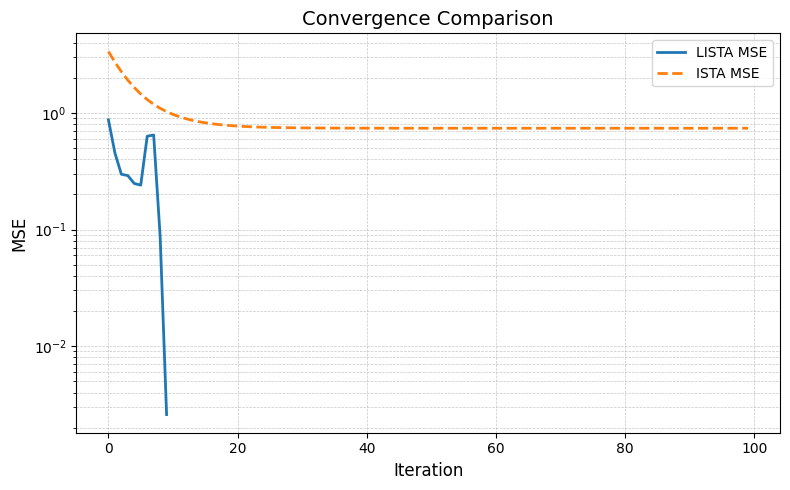

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(lista_mse_vs_iter, linestyle='-', color='C0', linewidth=2, label='LISTA MSE')
plt.plot(ista_mse_vs_iter, linestyle='--', color='C1', linewidth=2, label='ISTA MSE')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("Convergence Comparison", fontsize=14)
plt.yscale('log')

plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()


torch.Size([1, 200])


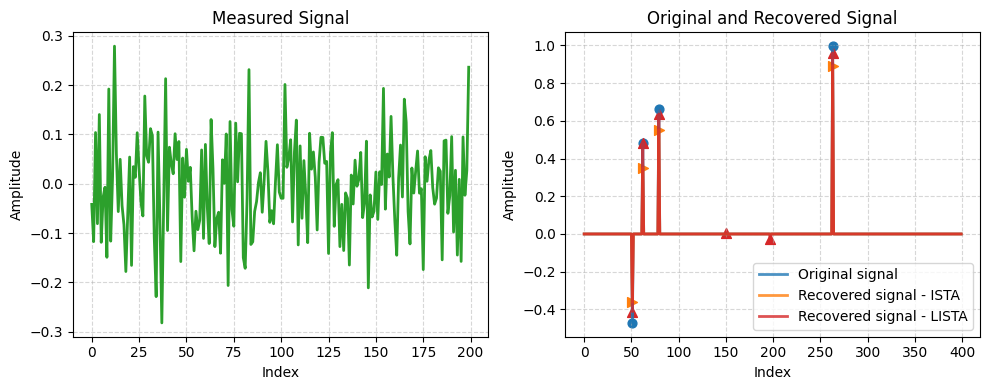

In [ ]:
x = X[:,0]
y = Y[:,0]
A = generator.A.cpu().numpy().astype(np.float32)

x_hat_ISTA = ISTA(A, y, 0.1)
x_hat_LISTA, _ = lista(torch.from_numpy(y.reshape(-1, 1).T))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

mask_X = np.abs(X[:, 0]) > 1e-3
mask_xhat_ISTA = np.abs(x_hat_ISTA) > 1e-3
mask_xhat_LISTA = np.abs(x_hat_LISTA[0].detach().numpy()) > 1e-3


axes[0].plot(Y[:, 0], linewidth = 2, color="tab:green")
axes[0].set_title("Measured Signal")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(X[:, 0], label="Original signal", linewidth = 2, color="tab:blue", alpha=0.8)
axes[1].plot(x_hat_ISTA, label="Recovered signal - ISTA", linewidth = 2, color="tab:orange", alpha=0.8)
axes[1].plot(x_hat_LISTA[0].detach().numpy(), label="Recovered signal - LISTA", linewidth = 2, color="tab:red", alpha=0.8)

axes[1].scatter(np.where(mask_X)[0], X[mask_X, 0], color="tab:blue", marker='o', s=40,)
axes[1].scatter(np.where(mask_xhat_ISTA)[0], x_hat_ISTA[mask_xhat_ISTA], color="tab:orange", marker='>', s=50,)
axes[1].scatter(np.where(mask_xhat_LISTA)[0], x_hat_LISTA[0].detach().numpy()[mask_xhat_LISTA], color="tab:red", marker='^', s=50,)

axes[1].set_title("Original and Recovered Signal")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Amplitude")
axes[1].legend(loc = 'lower right')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## ALISTA: making sense of model-based optimization, overcoming black-box learning

ISTA is an iterative algorithm with guarantees of convergence under blame assumptions; LISTA substitutes its interpretability with powerful, but black-box, data driven optimization. Is there something in between?
Clearly, yes :)

ALISTA is a generalization of LISTA meant to provide convergence guarantee, efficient training and powerful inference. It is based on the fact that the optimal recursion satisfies the following:

\begin{equation}
  \mathbf{x}^{k+1} = \mathbb{S}_{\beta^k} [ \mathbf{x}^k - \mu^k\mathbf{W}^\top(\mathbf{Ax}^k-\mathbf{y})]
\end{equation}

being $\mathbf{W}$ the solution to the problem of *maximum mutual incoherence*:

\begin{aligned}
\underset{\mathbf{W}}{\mathrm{min}} \ \ & \|\mathbf{W}^\top\mathbf{A}\|_F^2 \\
& \mathbf{W}_{:,m}^\top\mathbf{A}_{:,m} = 1, \forall m = 1,...,M
\end{aligned}

which is a convex problem, so we just need to call a solver!

In [ ]:
class ALISTA(nn.Module):
    def __init__(
        self,
        A,
        T=6,
        beta_0 = 0.1
        ):

        super(ALISTA, self).__init__()
        '''
        Your code goes here
        '''

        # Model Hyperparameters
        '''
        Your code goes here
        '''

        # "Linear Layers"
        self.W = self.W_preoptimization().to(self.device)
        '''
        Your code goes here
        '''

        # ALISTA parameters: threshold and stepsize
        '''
        Your code goes here
        '''

    def W_preoptimization(self):
        '''
        Your code goes here
        '''

    def _shrink(self, s, beta):
        '''
        Your code goes here
        '''

    def forward(self, y, x_true=None):
        '''
        Your code goes here
        '''

In [ ]:
def ALISTA_apply(train_loader, test_loader, T, A, beta_0):
    n = A.shape[0]
    m = A.shape[1]
    alista = ALISTA(A = A, T = T, beta_0 = beta_0)
    train(alista, train_loader, test_loader)

    # Extract all samples and calculate MSE for each iteration
    y, x_true = test_loader.dataset.tensors
    _, mse_vs_iter = alista(y, x_true=x_true)

    return lista, np.array(mse_vs_iter)/len(test_loader.dataset)

In [ ]:
alista, alista_mse_vs_iter = ALISTA_apply(train_loader, test_loader, 10, A_, 0.5)

Linear layer initialized minimizing coherence!
Epoch 0, Train loss 0.65006336, Validation loss 0.29057249
Epoch 10, Train loss 0.05656936, Validation loss 0.06446302
Epoch 20, Train loss 0.00988912, Validation loss 0.00915850
Epoch 30, Train loss 0.00371627, Validation loss 0.00375951
Epoch 40, Train loss 0.00253448, Validation loss 0.00270632


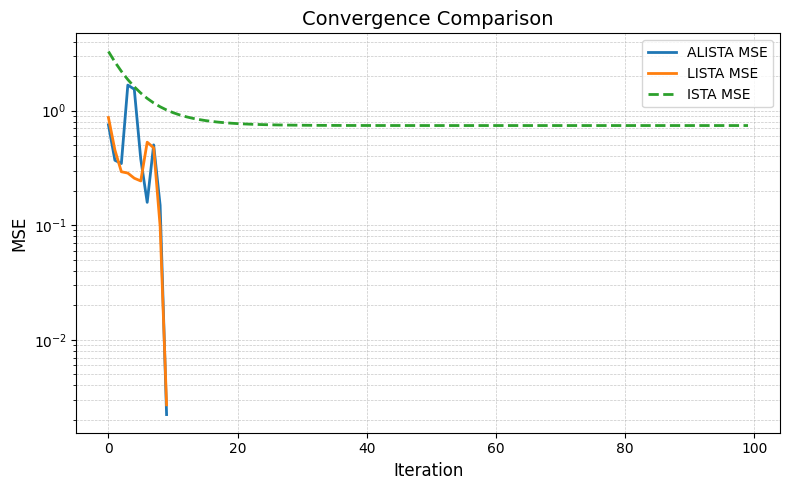

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(alista_mse_vs_iter, linestyle='-', color='C0', linewidth=2, label='ALISTA MSE')
plt.plot(lista_mse_vs_iter, linestyle='-', color='C1', linewidth=2, label='LISTA MSE')
plt.plot(ista_mse_vs_iter, linestyle='--', color='C2', linewidth=2, label='ISTA MSE')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.title("Convergence Comparison", fontsize=14)
plt.yscale('log')

plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# References


+ Fornasier, Massimo, and Holger Rauhut. "Iterative thresholding algorithms." Applied and Computational Harmonic Analysis 25.2 (2008): 187-208.
+ Gregor, Karol, and Yann LeCun. "Learning fast approximations of sparse coding." Proceedings of the 27th international conference on international conference on machine learning. 2010.
+ Davenport, Mark A., et al. "Introduction to compressed sensing." (2012): 1-64.
+ Shlezinger, Nir, et al. "Model-based deep learning." Proceedings of the IEEE 111.5 (2023): 465-499.
+ Liu, Jialin, et al. "ALISTA: Analytic weights are as good as learned weights in LISTA." International conference on learning representations. 2019.
